<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Projet3_Grad_Cam_pour_analyse_d'images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM: How to visualize class activation maps to bring Interpretability to Deep Learning

 🌟 IMPORTANT : Si vous êtes un étudiant, cliquez sur "Fichier -> Enregistrer une copie dans Drive" avant de l'utiliser.

Dans ce tutoriel, vous allez apprendre à visualiser les cartes d'activation de classe en utilisant un algorithme appelé Grad-CAM (article original ici : https://arxiv.org/pdf/1611.07450.pdf). L'implémentation se fera avec Keras, en s'inspirant du code proposé par F. Chollet (https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py).

Les modèles de Deep Learning sont souvent considérés comme des modèles de type "boîte noire", car nous ne savons pas pourquoi une certaine sortie est associée à une certaine entrée.

Comme expliqué dans l'article original, "Grad-CAM utilise le gradient de tout concept cible (par exemple, les logits pour 'chien' ou même une légende prédite pour une image d'entrée), en le faisant passer dans la dernière couche de convolution pour produire une carte de localisation grossière qui met en évidence les régions importantes de l'image pour prédire le concept."

Pour simplifier, la méthode Grad-CAM permet de comprendre quelle partie de l'image a été utilisée par le modèle pour prendre sa décision, ou plus précisément, quelle partie de l'image a le plus contribué à sa prédiction.

🚀 Pourquoi vouloir visualiser les cartes d'activation de classe dans les réseaux neuronaux convolutifs ?
En réalité, nous voulons nous assurer que le modèle prend une décision pour les bonnes raisons et qu'il n'est pas biaisé. Concrètement, prenons un exemple : nous souhaitons que le modèle détecte un lapin parce qu'il ressemble à un lapin, et non parce qu'il y a une carotte et une cuisine en arrière-plan. Cela garantit que le modèle peut détecter un lapin dans n'importe quel contexte.

Le concept est simple et direct :


1.   Trouver et isoler la dernière couche de convolution dans un réseau neuronal profond pré-entraîné.
2.   Calculer le gradient qui traverse cette couche et colorier ses valeurs sous forme de carte thermique.




## 🟢 Configuration

Chargement des bibliothèques

In [1]:
# Usual Imports for Deep Learning
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Nous allons utiliser le modèle Xception (documentation ici : https://keras.io/api/applications/xception/).

🔧 Nous utilisons model.summary() pour afficher les noms de toutes les couches du modèle et identifier le nom de la dernière couche convolutionnelle.

In [15]:
# Prepare the model. model_builder() is used to load Xception with Keras
# You can check the documentation of those functions on https://www.tensorflow.org
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions


# Create the model, by using pretrained weights on ImageNet
model = model_builder(weights="imagenet")
#print(model.summary())

A cette étape nous préparons :



*   Les couches à analyser
*   L'image d'entrée
*   L'affichage visuel de l'image pour un aperçu rapide.







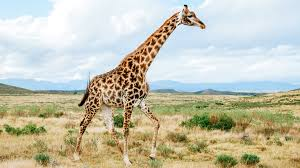

In [10]:
# Isolate the last convolutional layer
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
# img_path = keras.utils.get_file(
#     "rabbit.jpg", "https://i.imgur.com/vH1MxgA.png"
# )

img_path = "girafe.jpg"
# Visualize the image
display(Image(img_path))

## The Grad-CAM algorithm

In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3). We do this because this dimension is needed for most built-in functions
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    # The variable "prediction_rank" is used to apply gradcam on the top class
    # You can modify it to prediction_rank=n for a heatmap on the nth top class

    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # GradientTape() is a built-in Tensorflow tool to record operations for automatic differentiation.
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # We compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        # We pass the activations of the last conv in our classifier_model to obtain the predictions of the model
        preds = classifier_model(last_conv_layer_output)
        # This prediction has a shape=(1, 1000) because there is 1000 classes in ImageNet.
        # We find the index of the top prediction and we call it pred_index, because it's the index of the prediction
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        # We only keep the value of the prediction at the position of the pred_index
        top_class_channel = preds[:, pred_index]


    # This is the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation for the top class
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's use it

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Top 1 Prediction: [('n02130308', 'cheetah', 0.437333)]
Top 3 Predictions: [('n02130308', 'cheetah', 0.437333), ('n02423022', 'gazelle', 0.11089482), ('n02128385', 'leopard', 0.08995536)]


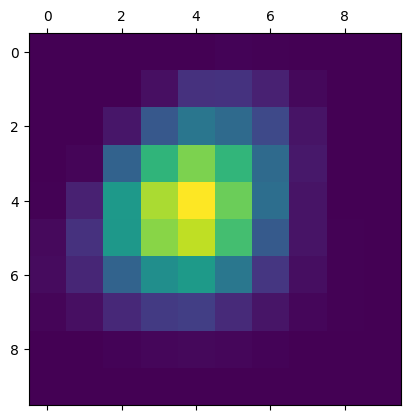

In [13]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is (Angora stands for Angora Rabbit in ImageNet labels)
# According to https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/decode_predictions
# decode_predictions() returns a list of lists of top class prediction tuples (class_name, class_description, score)
# class_name is the internal name of the class, class_description the name in natural language and score is the probability of this prediction.
# top=1 is used to have the top class and [0] to have the first element of the list.
preds = model.predict(img_array)
print("Top 1 Prediction:", decode_predictions(preds, top=1)[0])

# In order to check the 2nd and 3rd predicted class, we also print the predictions with top=3
print("Top 3 Predictions:", decode_predictions(preds, top=3)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap. This heatmap is normalized for visualisation purpose, as explained in make_gradcam_heatmap()
# Thanks to that, we can know what part of the image was the most important to predict the top class
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it

<ipython-input-14-5ca61a271316>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


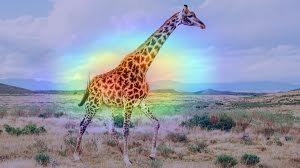

In [14]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255 (because earlier, for visualization purpose, we normalized the heatmap between 0 & 1)
# We rescale it on this range to have it in RGB, so that we can superimpose it on the rabbit picture.
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "rabbit_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

## Perfect!

Now we know that the model "looked" at the center of the image, where the head of the rabbit is located, in order to make its prediction.

We can be glad we have a rabbit detector and not a carrot or a kitchen detector!

You can now have fun by testing this method on other images!